In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2 , mutual_info_classif
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress

In [2]:
print(os.getcwd())


C:\Users\חנן\Desktop\אריאל אונ'\שנה ג\זיהוי התקפות\תרגיל\תרגיל\attribution


In [3]:
def select_features(X, y, correlation_matrix, correlation_threshold=0.95):
    # Remove highly correlated features
    highly_correlated = np.where(np.abs(correlation_matrix) > correlation_threshold)
    highly_correlated = [(correlation_matrix.index[x], correlation_matrix.columns[y]) 
                        for x, y in zip(*highly_correlated) if x != y and x < y]
    
    features_to_drop = set()
    for feat1, feat2 in highly_correlated:
        if feat1 not in features_to_drop:
            features_to_drop.add(feat2)
    
    X = X.drop(columns=list(features_to_drop))
    
    # Select best features using mutual information
    selector = SelectKBest(score_func=mutual_info_classif, k='all')
    # selector = SelectKBest(score_func=lambda X, y: mutual_info_classif(X, y, random_state=42), k='all')
    selector.fit(X, y)
    
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    })
    
    print("\nTop 20 features by mutual information:")
    print(feature_scores.sort_values('Score', ascending=False).head(30))
    
    # Select top features
    k = 30  # Number of features to select
    best_features = feature_scores.nlargest(k, 'Score')['Feature'].tolist()
    
    return X[best_features]

In [4]:
# Load the datasets
#train_df = pd.read_csv('train.csv')
train_df = pd.read_csv(r"C:\Users\חנן\Desktop\אריאל אונ'\שנה ג\זיהוי התקפות\תרגיל\תרגיל\attribution\train.csv")
#test_df = pd.read_csv('test.csv')
test_df = pd.read_csv(r"C:\Users\חנן\Desktop\אריאל אונ'\שנה ג\זיהוי התקפות\תרגיל\תרגיל\attribution\test.csv")

# Print column names to verify
print("Available columns:")
print(train_df.columns.tolist())

Available columns:
['Source_IP', 'Source_port', 'Destination_IP', 'Destination_port', 'Protocol', 'Timestamp', 'fwd_packets_amount', 'bwd_packets_amount', 'fwd_packets_length', 'bwd_packets_length', 'max_fwd_packet ', 'min_fwd_packet', 'max_bwd_packet', 'min_bwd_packet', 'FIN_count', 'SYN_count', 'RST_count', 'PSH_count', 'silence_windows', 'min_fwd_inter_arrival_time', 'max_fwd_inter_arrival_time', 'mean_fwd_inter_arrival_time', 'min_bwd_inter_arrival_time', 'max_bwd_inter_arrival_time', 'mean_bwd_inter_arrival_time', 'min_bib_inter_arrival_time', 'max_bib_inter_arrival_time', 'mean_bib_inter_arrival_time', 'first_packet_sizes_0', 'first_packet_sizes_1', 'first_packet_sizes_2', 'first_packet_sizes_3', 'first_packet_sizes_4', 'first_packet_sizes_5', 'first_packet_sizes_6', 'first_packet_sizes_7', 'first_packet_sizes_8', 'first_packet_sizes_9', 'first_packet_sizes_10', 'first_packet_sizes_11', 'first_packet_sizes_12', 'first_packet_sizes_13', 'first_packet_sizes_14', 'first_packet_sizes

In [5]:
def extract_ip_features(ip_str):
    """Extract meaningful features from IP address"""
    try:
        ip = ipaddress.ip_address(ip_str)
        return {
            'is_private': int(ip.is_private),
            'is_global': int(ip.is_global),
            'ip_version': int(ip.version),
            'ip_first_octet': int(str(ip).split('.')[0]),
            'ip_second_octet': int(str(ip).split('.')[1]),
            'ip_third_octet': int(str(ip).split('.')[2]),
            'ip_fourth_octet': int(str(ip).split('.')[3])
        }
    except:
        return {
            'is_private': 0,
            'is_global': 0,
            'ip_version': 4,
            'ip_first_octet': 0,
            'ip_second_octet': 0,
            'ip_third_octet': 0,
            'ip_fourth_octet': 0
        }

In [6]:
# Process IP addresses
for ip_col in ['Source_IP', 'Destination_IP']:
    # Extract features for training data
    ip_features_train = pd.DataFrame([
        extract_ip_features(ip) for ip in train_df[ip_col]
    ]).add_prefix(f'{ip_col}_')
    
    # Extract features for test data
    ip_features_test = pd.DataFrame([
        extract_ip_features(ip) for ip in test_df[ip_col]
    ]).add_prefix(f'{ip_col}_')
    
    # Add new features to dataframes
    train_df = pd.concat([train_df, ip_features_train], axis=1)
    test_df = pd.concat([test_df, ip_features_test], axis=1)
    
    # Drop original IP columns
    train_df.drop(ip_col, axis=1, inplace=True)
    test_df.drop(ip_col, axis=1, inplace=True)

In [7]:
# Label encode Protocol
le_protocol = LabelEncoder()
train_df['Protocol'] = le_protocol.fit_transform(train_df['Protocol'])
test_df['Protocol'] = le_protocol.transform(test_df['Protocol'])

In [8]:
# Convert timestamp to numeric and extract more features
train_df['Timestamp'] = pd.to_numeric(train_df['Timestamp'])
test_df['Timestamp'] = pd.to_numeric(test_df['Timestamp'])

In [9]:
# Add time-based features
for df in [train_df, test_df]:
    df['Timestamp_hour'] = pd.to_datetime(df['Timestamp'], unit='s').dt.hour
    df['Timestamp_minute'] = pd.to_datetime(df['Timestamp'], unit='s').dt.minute
    df['Timestamp_dayofweek'] = pd.to_datetime(df['Timestamp'], unit='s').dt.dayofweek
    df['Timestamp_isweekend'] = df['Timestamp_dayofweek'].isin([5, 6]).astype(int)
    
    # Add custom ratios based on available columns
    df['packets_ratio'] = df['fwd_packets_amount'] / df['bwd_packets_amount']
    df['packets_length_ratio'] = df['fwd_packets_length'] / df['bwd_packets_length']
    
    # Add packet size features
    df['total_packets'] = df['fwd_packets_amount'] + df['bwd_packets_amount']
    df['total_length'] = df['fwd_packets_length'] + df['bwd_packets_length']
    df['avg_packet_size'] = df['total_length'] / df['total_packets']
    
    # Add flag-based features
    df['total_flags'] = df['FIN_count'] + df['SYN_count'] + df['RST_count'] + df['PSH_count']
    
    # Add timing-based features
    df['timing_ratio'] = df['mean_fwd_inter_arrival_time'] / df['mean_bwd_inter_arrival_time']
    df['total_silence'] = df['silence_windows']

In [9]:
# Drop original timestamp
train_df.drop('Timestamp', axis=1, inplace=True)
test_df.drop('Timestamp', axis=1, inplace=True)

# Handle infinite values
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.replace([np.inf, -np.inf], np.nan)

# Fill NaN values with 0
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [10]:
# Separate features and target
X_train = train_df.drop(['attribution'], axis=1)
y_train = train_df['attribution']
X_test = test_df.drop(['attribution'], axis=1)
y_test = test_df['attribution']

In [11]:
# Remove constant features
constant_columns = [col for col in X_train.columns if X_train[col].nunique() <= 1]
X_train = X_train.drop(constant_columns, axis=1)
X_test = X_test.drop(constant_columns, axis=1)

print(f"Features after removing constants: {X_train.shape[1]}")

Features after removing constants: 85


In [12]:
col_to_drop = select_features(X_train, y_train,X_train.corr())
X_train = X_train.drop(col_to_drop, axis=1)
X_test = X_test.drop(col_to_drop, axis=1)

print(f"Features after removing col_to_drop: {X_train.shape[1]}")


Top 20 features by mutual information:
                       Feature     Score
8               min_bwd_packet  1.980525
6               min_fwd_packet  1.891827
55    Source_IP_ip_first_octet  1.631990
21        first_packet_sizes_6  1.594825
2                     Protocol  1.503660
19        first_packet_sizes_4  1.486198
7               max_bwd_packet  1.381421
45             min_packet_size  1.356036
17        first_packet_sizes_2  1.337633
20        first_packet_sizes_5  1.217881
22        first_packet_sizes_7  1.196203
1             Destination_port  1.178450
10                   SYN_count  1.051220
18        first_packet_sizes_3  0.917676
14  min_fwd_inter_arrival_time  0.861595
5              max_fwd_packet   0.859432
54                   ACK_count  0.858041
12                   PSH_count  0.855090
36       first_packet_sizes_21  0.811419
47             STD_packet_size  0.796718
9                    FIN_count  0.791567
56   Source_IP_ip_second_octet  0.788357
49              S

In [13]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [14]:
# Random Forest with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    # min_samples_split=2,
    # min_samples_leaf=1,
    # max_features='sqrt',
    random_state=82,
    n_jobs=-1,
    # class_weight='balanced'
)

# Train the model
print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)

Training Random Forest...


RandomForestClassifier(n_jobs=-1, random_state=82)

In [15]:
# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Print results
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print(f"RandomForestClassifier Accuracy on Test Dataset: {accuracy_score(y_test, y_pred):.4f}")



Classification Report:
                     precision    recall  f1-score   support

                VOD       0.80      0.80      0.80         5
      file download       0.83      1.00      0.91         5
    real_time_audio       1.00      0.60      0.75         5
real_time_messaging       1.00      1.00      1.00         5
    real_time_video       0.67      0.80      0.73         5

           accuracy                           0.84        25
          macro avg       0.86      0.84      0.84        25
       weighted avg       0.86      0.84      0.84        25


Accuracy Score: 0.84
RandomForestClassifier Accuracy on Test Dataset: 0.8400



Top 20 Most Important Features:
                          feature  importance
51  Destination_IP_ip_first_octet    0.058132
0                     Source_port    0.048249
11    mean_bib_inter_arrival_time    0.046625
21          first_packet_sizes_17    0.041633
10     max_bib_inter_arrival_time    0.040401
34                    bandwidth_1    0.039207
53  Destination_IP_ip_third_octet    0.036167
32                max_packet_size    0.034204
8     mean_bwd_inter_arrival_time    0.034013
46             count_big_requests    0.030016
7      max_bwd_inter_arrival_time    0.029602
33                mean_delta_byte    0.027233
37                    bandwidth_5    0.025529
48      Source_IP_ip_fourth_octet    0.025346
44                        pps_fwd    0.025269
12           first_packet_sizes_0    0.024651
25          first_packet_sizes_22    0.022218
30          first_packet_sizes_28    0.021640
38                          bpp_0    0.020022
13           first_packet_sizes_1    0.019611


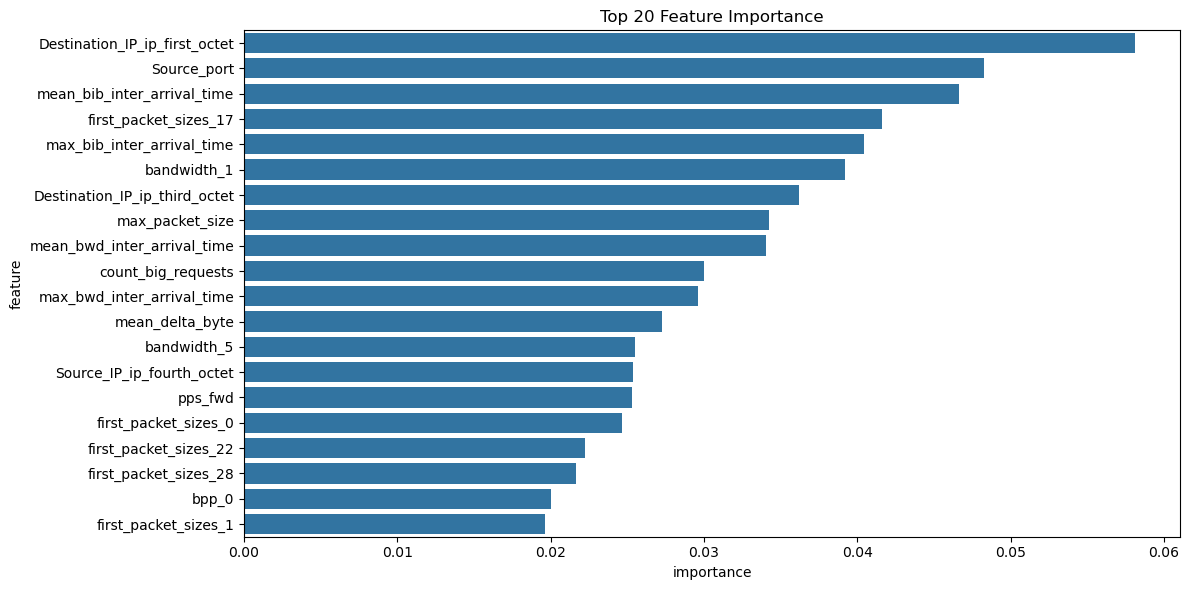

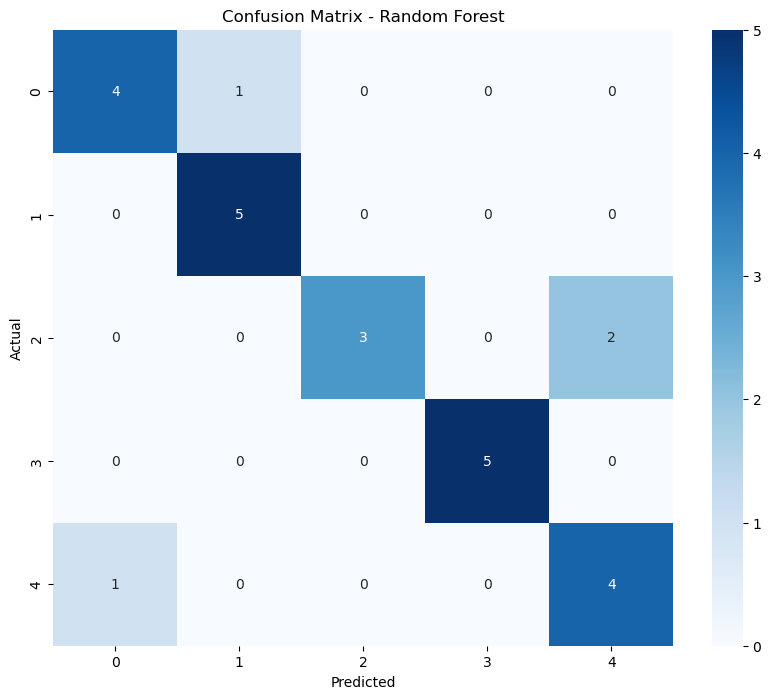

In [16]:
# Feature importance analysis
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

top_features = importances.head(6)['feature'].tolist()
X_train_top = X_train_scaled[top_features]
X_test_top = X_test_scaled[top_features]

print("\nTop 20 Most Important Features:")
print(importances.head(20))

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importances.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
top_features

['Destination_IP_ip_first_octet',
 'Source_port',
 'mean_bib_inter_arrival_time',
 'first_packet_sizes_17',
 'max_bib_inter_arrival_time',
 'bandwidth_1']

In [18]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [19]:
# Using also Bagging Classifier
bagging_model = BaggingClassifier(
    estimator=rf_model,
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)

# Train the model
print("Training Bagging Classifier...")
bagging_model.fit(X_train_top, y_train_encoded)

# Make predictions
y_pred_bg = bagging_model.predict(X_test_top)

# Print results
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_bg))
print("\nAccuracy Score:", accuracy_score(y_test_encoded, y_pred_bg))
accuracy_bagging = accuracy_score(y_test_encoded, y_pred_bg)
print(f"BaggingClassifier Accuracy on Test Dataset: {accuracy_bagging:.4f}")


Training Bagging Classifier...

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.71      1.00      0.83         5
           2       0.40      0.40      0.40         5
           3       1.00      1.00      1.00         5
           4       0.60      0.60      0.60         5

    accuracy                           0.68        25
   macro avg       0.68      0.68      0.67        25
weighted avg       0.68      0.68      0.67        25


Accuracy Score: 0.68
BaggingClassifier Accuracy on Test Dataset: 0.6800


In [43]:
# from sklearn.neighbors import KNeighborsClassifier

# # Initialize KNN model
# knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors as needed

# # Train the KNN model
# print("Training KNN Classifier...")
# knn_model.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred_knn = knn_model.predict(X_test_scaled)

# # Print results
# print("\nClassification Report for KNN:")
# print(classification_report(y_test, y_pred_knn))
# print("\nAccuracy Score for KNN:", accuracy_score(y_test, y_pred_knn))
# accuracy_knn = accuracy_score(y_test, y_pred_knn)
# print(f"KNN Classifier Accuracy on Test Dataset: {accuracy_knn:.4f}")